In [1]:
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
import efficientnet.tfkeras as efn 
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

In [2]:
def build_efn(numColors,finalAct="softmax"):
    # initialize the input shape and channel dimension (this code
    # assumes you are using TensorFlow which utilizes channels
    # last ordering)
    inputShape = (224, 224, 3)
    base_model = efn.EfficientNetB0(weights='imagenet',include_top=False,input_shape = inputShape)    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D(name="gap"))
    model.add(Dropout(0.5))
    model.add(Dense(numColors,activation=finalAct,name="color_output"))

    return model

def build(width, height, numColors,
    finalAct="softmax"):
    # initialize the input shape and channel dimension (this code
    # assumes you are using TensorFlow which utilizes channels
    # last ordering)
    inputShape = (height, width, 3)
    chanDim = -1

    # construct both the "category" and "color" sub-networks
    inputs = Input(shape=inputShape)

    colorBranch = build_color_branch(inputs,
        numColors, finalAct=finalAct, chanDim=chanDim)

    # create the model using our input (the batch of images) and
    # two separate outputs -- one for the clothing category
    # branch and another for the color branch, respectively
    model = Model(
        inputs=inputs,
        outputs=colorBranch,
        name="colornet")

    # return the constructed network architecture
    return model

def build_color_branch(inputs, numColors, finalAct="softmax",
    chanDim=-1):
    # CONV => RELU => POOL
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)

    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # CONV => RELU => POOL
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # define a branch of output layers for the number of different
    # colors (i.e., red, black, blue, etc.)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(numColors)(x)
    x = Activation(finalAct, name="color_output")(x)

    # return the color prediction sub-network
    return x

In [3]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 30
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (128, 128, 3)

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('../dataset_resize_128/')))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [4]:
# initialize the data, clothing category labels (i.e., shirts, jeans,
# dresses, etc.) along with the color labels (i.e., red, blue, etc.)
data = []
colorLabels = []

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
# 	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)

	# extract the clothing color and category from the path and
	# update the respective lists
	(color, cat) = imagePath.split(os.path.sep)[-2].split("_")
	colorLabels.append(color)

# scale the raw pixel intensities to the range [0, 1] and convert to
# a NumPy array
data = np.array(data, dtype="float") / 255.0
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))


[INFO] data matrix: 3272 images (1256.45MB)


In [5]:
print(np.unique(colorLabels))
# binarize both sets of labels
print("[INFO] binarizing labels...")
colorLB = LabelBinarizer()
colorLabels = colorLB.fit_transform(colorLabels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data,colorLabels,stratify = colorLabels,
	test_size=0.2)
(trainX, testX, trainColorY, testColorY) = split

['black' 'blue' 'brown' 'gray' 'green' 'orange' 'pink' 'purple' 'red'
 'silver' 'white' 'yellow']
[INFO] binarizing labels...


In [6]:
# model = build(numColors=len(colorLB.classes_),finalAct="softmax")
model = build(IMAGE_DIMS[0], IMAGE_DIMS[1],numColors=len(colorLB.classes_),
    finalAct="softmax")

model.summary()
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "colornet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 16)        0         
___________________________________________

In [7]:
checkpoint = ModelCheckpoint('output/bestmodel.h5', monitor='val_loss', verbose=1, save_best_only=True)
history = model.fit(trainX, trainColorY,
              batch_size=32,
              epochs=50,
              validation_data=(testX, testColorY),
              callbacks=[EarlyStopping(monitor='val_loss', patience=5),checkpoint], 
              verbose=1 )

Train on 2617 samples, validate on 655 samples
Epoch 1/50
2560/2617 [============================>.] - ETA: 0s - loss: 1.1796 - acc: 0.6719
Epoch 00001: val_loss improved from inf to 3.15306, saving model to output/bestmodel.h5
2617/2617 [==============================] - 5s 2ms/sample - loss: 1.1650 - acc: 0.6756 - val_loss: 3.1531 - val_acc: 0.3435
Epoch 2/50
2592/2617 [============================>.] - ETA: 0s - loss: 0.5251 - acc: 0.8345
Epoch 00002: val_loss did not improve from 3.15306
2617/2617 [==============================] - 2s 580us/sample - loss: 0.5243 - acc: 0.8345 - val_loss: 3.2409 - val_acc: 0.1557
Epoch 3/50
2528/2617 [===========================>..] - ETA: 0s - loss: 0.3977 - acc: 0.8742
Epoch 00003: val_loss improved from 3.15306 to 3.06240, saving model to output/bestmodel.h5
2617/2617 [==============================] - 2s 592us/sample - loss: 0.3964 - acc: 0.8739 - val_loss: 3.0624 - val_acc: 0.1496
Epoch 4/50
2560/2617 [============================>.] - ETA: 0s 

In [8]:
print("[INFO] serializing color label binarizer...")
f = open('output/color_lb.pickle', "wb")
f.write(pickle.dumps(colorLB))
f.close()

[INFO] serializing color label binarizer...


In [9]:
def plotresult(History):
    %matplotlib inline
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(History.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(History.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(History.history['loss'])
    plt.ylabel('categorical_crossentropy Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(History.history['val_loss'])
    plt.xlabel('epochs')

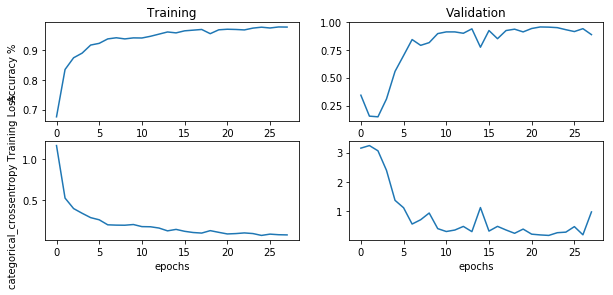

In [10]:
plotresult(history)

In [16]:

from sklearn.metrics import classification_report
model.load_weights('output/bestmodel.h5')
yhat = np.argmax(model.predict(testX),axis=1)
label = np.argmax(testColorY,axis=1)

In [22]:
print(classification_report(label, yhat, target_names=colorLB.classes_))

              precision    recall  f1-score   support

       black       0.95      0.97      0.96       149
        blue       0.99      0.96      0.98       222
       brown       1.00      0.88      0.94        17
        gray       0.71      0.88      0.79        17
       green       1.00      0.88      0.94        17
      orange       0.94      0.94      0.94        18
        pink       0.86      0.95      0.90        19
      purple       1.00      0.94      0.97        18
         red       0.99      0.98      0.99       142
      silver       0.60      0.38      0.46         8
       white       0.59      1.00      0.74        10
      yellow       0.95      1.00      0.97        18

    accuracy                           0.95       655
   macro avg       0.88      0.90      0.88       655
weighted avg       0.96      0.95      0.95       655



In [38]:


from sklearn.metrics import confusion_matrix

labels = colorLB.classes_
cm = confusion_matrix(label, yhat)
print(cm)


[[144   1   0   4   0   0   0   0   0   0   0   0]
 [  2 214   0   0   0   0   0   0   0   2   4   0]
 [  1   0  15   0   0   0   0   0   1   0   0   0]
 [  1   0   0  15   0   0   0   0   0   0   1   0]
 [  2   0   0   0  15   0   0   0   0   0   0   0]
 [  0   0   0   0   0  17   0   0   0   0   0   1]
 [  0   1   0   0   0   0  18   0   0   0   0   0]
 [  0   0   0   0   0   0   1  17   0   0   0   0]
 [  0   0   0   0   0   1   2   0 139   0   0   0]
 [  1   0   0   2   0   0   0   0   0   3   2   0]
 [  0   0   0   0   0   0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0  18]]


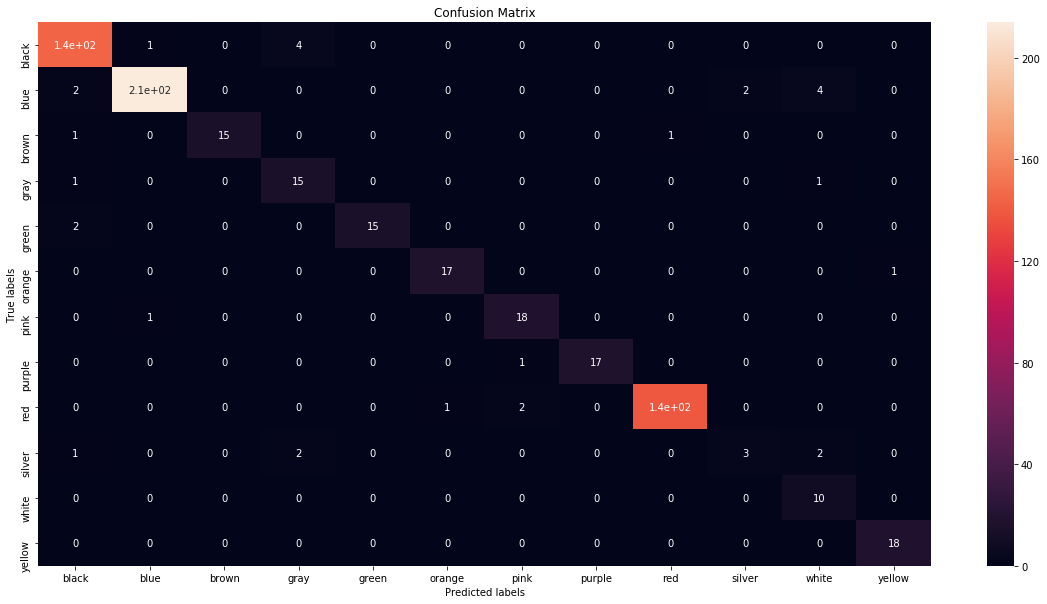

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt     

plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);